In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 26 12:57:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
pip install pyldavis==3.3.1 --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136880 sha256=0a1a57ff773d67568dcabf3122805824b32e9d3c64a0633a007d9fb024168212
  Stored in directory: /root/.cache/pip/wheels/e9/95/74/4766157910829d2fbc6b913850a62cfd15da77a199302cdf9c
Successfully built pyldavis


In [5]:
pip install funcy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires sklearn, which is not installed.


In [6]:
import pickle
import pandas as pd
import numpy as np
import sklearn
import IPython.display
import re

# Permettra de créer des accés avec google drive
import os

# Pour l'optimisation des algos :
from sklearn.model_selection import GridSearchCV

# pour les algorithmes supervisés :
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

# Pour le BOW :
from nltk.tokenize import word_tokenize

# Pour le tf-idf :
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow_hub as tf_hub

# Pour word2vec :
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
from gensim.models import Word2Vec, word2vec

# Pour la visualisation des tokens :
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

# Pour la visu du LDA
import pyLDAvis

# Pour les scores :
from sklearn import metrics
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss
from sklearn.metrics import roc_auc_score

# Pour supprimer les warnings :
import warnings
warnings.filterwarnings("ignore")

# Permet de convertir des strings représentant des listes de mots en de vraies listes 
from ast import literal_eval

In [7]:
df = pd.read_csv('/content/drive/MyDrive/IML OPENCLASSROOMS/PROJET_5/df_1.csv', converters={'Top_tags' : literal_eval})

In [8]:
df.shape

(44125, 6)

In [9]:
df.head(5)

,Top_tags,Post,Post_clean_html,post_cleaned,post_tokenized,post_lemmatized
0,[android],How do i add android tools to my path on mac? ...,How do i add android tools to my path on mac? ...,how do i add android tools to my path on mac i...,"['add', 'android', 'tools', 'path', 'mac', 'tr...","['add', 'android', 'tool', 'path', 'mac', 'try..."
1,[mysql],Query Returns No Results Only When ORDER BY Ad...,Query Returns No Results Only When ORDER BY Ad...,query returns no results only when order by ad...,"['query', 'returns', 'results', 'order', 'adde...","['query', 'return', 'result', 'order', 'added'..."
2,[c],Switch case help in C <p>I am in 9th class so ...,Switch case help in C I am in 9th class so sti...,switch case help in c i am in th class so stil...,"['switch', 'case', 'help', 'c', 'th', 'class',...","['switch', 'case', 'help', 'c', 'th', 'class',..."
3,[mysql],AWS RDS Performance Insights - view full queri...,AWS RDS Performance Insights - view full queri...,aws rds performance insights view full queries...,"['aws', 'rds', 'performance', 'insights', 'vie...","['aws', 'rds', 'performance', 'insight', 'view..."
4,[sql],Generating cryptographic secure IDs instead of...,Generating cryptographic secure IDs instead of...,generating cryptographic secure ids instead of...,"['generating', 'cryptographic', 'secure', 'ids...","['generating', 'cryptographic', 'secure', 'id'..."


In [10]:
import re

def clean_text(text):
    # Supprimer les apostrophes
    text = re.sub(r"\'", "", text)
    # Supprimer les virgules
    text = re.sub(r",", "", str(text))
    # Supprimer les occurrences de "x" qui sont entourées d'espaces
    text = re.sub(r"\s+x\s+", " ", text)
    return text

# Appliquer la fonction de nettoyage à chaque document
df['post_lemmatized'] = df['post_lemmatized'].apply(clean_text)

In [11]:
df_modelisation = df[['Top_tags', 'post_lemmatized']]
df_modelisation.head(5)

,Top_tags,post_lemmatized
0,[android],[add android tool path mac trying add get andr...
1,[mysql],[query return result order added table followi...
2,[c],[switch case help c th class still beginner c ...
3,[mysql],[aws rds performance insight view full query u...
4,[sql],[generating cryptographic secure id instead se...


# **Approche non supervisée**

## **Countvectorizer BOW + LDA**

In [26]:
import nltk
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 10

In [27]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary

# Initialiser CountVectorizer avec les paramètres de votre choix
vectorizer = CountVectorizer(max_df=0.95, min_df=0.2, max_features=1000, stop_words='english')

# Créer la matrice document-terme à partir des textes lemmatisés
bow = vectorizer.fit_transform(df_modelisation['post_lemmatized'])

# Obtenir les noms de chaque terme (mot) de la matrice document-terme
terms = vectorizer.get_feature_names_out()

# Créer une liste de listes de mots pour chaque document
doc_list = [doc.split() for doc in df_modelisation['post_lemmatized']]

# Créer le dictionnaire Gensim à partir des données
id2word = Dictionary(doc_list)

# Appliquer le filtre no_below pour supprimer les termes qui apparaissent dans moins de 2 documents
id2word.filter_extremes(no_below=2)

# Créer le corpus Gensim (une représentation vectorielle de chaque document en fonction de la fréquence des termes)
corpus = [id2word.doc2bow(doc) for doc in doc_list]

CPU times: user 12.2 s, sys: 389 ms, total: 12.6 s
Wall time: 12.6 s


In [ ]:
%%time
# Créer le modèle LDA avec Gensim
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=42)

CPU times: user 30.5 s, sys: 451 ms, total: 30.9 s
Wall time: 30.5 s


In [ ]:
def display_topics(model, num_topics, num_words):
    topics = model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    for topic_idx, topic in topics:
        print("Topic {}:".format(topic_idx))
        print(" ".join([word for word, _ in topic]))

In [ ]:
num_topics = 10
num_words = 10
display_topics(lda_model, num_topics, num_words)

Topic 0:
public view android override void new import button activity eandroidruntime
Topic 1:
c int function const b code return include type compiler
Topic 2:
array string thread time import python return m code def
Topic 3:
function var user get page using return code php javascript
Topic 4:
file error line project version using run path command app
Topic 5:
table query null data select id using server database new
Topic 6:
div image px text width height cs html using element
Topic 7:
n number l time date column value var k list
Topic 8:
public class string new return object type get void private
Topic 9:
would code use like test question method way one java


In [ ]:
%%time
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
# Visualiser les topics avec pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, id2word, )R=10
pyLDAvis.display(vis_data)

CPU times: user 18.6 s, sys: 879 ms, total: 19.4 s
Wall time: 20.9 s




**- Convertir la matrice document-terme au format Gensim. Cela peut être fait à l'aide de la fonction matutils.Sparse2Corpus de la bibliothèque Gensim.**

**- Créer un dictionnaire Gensim à partir de la matrice document-terme. Cela peut être fait à l'aide de la fonction corpora.Dictionary de la bibliothèque Gensim.**

**- Entraîner le modèle LDA sur la matrice document-terme à l'aide de la fonction models.ldamodel.LdaModel de la bibliothèque Gensim.**



In [ ]:
%%time  
# Récupérer les mots clés pour chaque topic
topics = lda_model.show_topics(formatted=False)
topic_terms = {}
for topic_id, terms in topics:
    topic_terms[topic_id] = tuple(term for term, _ in terms if term)
    
# Remplacer les indexes des topics par les mots clés associés
topic_distribution = pd.DataFrame([dict(lda_model.get_document_topics(doc)) for doc in corpus])
topic_distribution = topic_distribution.rename(columns=topic_terms)
display(topic_distribution.head(10))

,"(file, error, line, project, version, using, run, path, command, app)","(public, class, string, new, return, object, type, get, void, private)","(would, code, use, like, test, question, method, way, one, java)","(c, int, function, const, b, code, return, include, type, compiler)","(table, query, null, data, select, id, using, server, database, new)","(public, view, android, override, void, new, import, button, activity, eandroidruntime)","(array, string, thread, time, import, python, return, m, code, def)","(div, image, px, text, width, height, cs, html, using, element)","(n, number, l, time, date, column, value, var, k, list)","(function, var, user, get, page, using, return, code, php, javascript)"
0,0.885501,0.026212,0.072261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.158245,NaN,0.030558,0.807581,NaN,NaN,NaN,NaN,NaN
2,0.059452,NaN,NaN,0.497680,NaN,0.016444,0.146544,0.023765,0.254409,NaN
3,NaN,NaN,0.449357,0.090407,0.446745,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.378487,NaN,0.174598,NaN,0.042126,NaN,0.337658,0.061611
5,NaN,NaN,NaN,NaN,0.010763,NaN,NaN,0.028677,0.261270,0.694966
6,0.360896,0.029216,NaN,NaN,0.131732,NaN,NaN,0.305488,NaN,0.168482
7,NaN,0.262100,0.111799,0.493810,0.020716,NaN,NaN,0.076819,0.030737,NaN
8,NaN,0.062582,0.189337,NaN,0.050621,NaN,NaN,0.602742,0.087913,NaN
9,0.198049,NaN,0.529403,0.090685,NaN,NaN,NaN,NaN,0.170052,NaN


CPU times: user 21.1 s, sys: 451 ms, total: 21.6 s
Wall time: 21.2 s


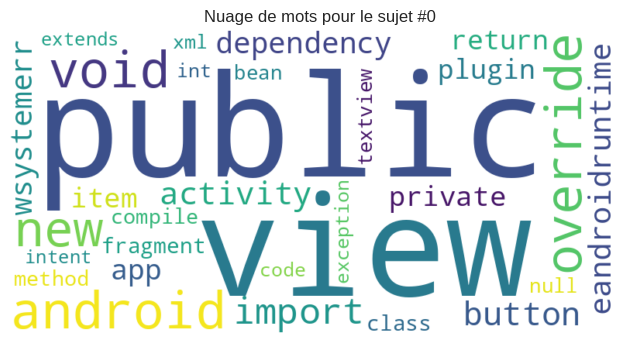

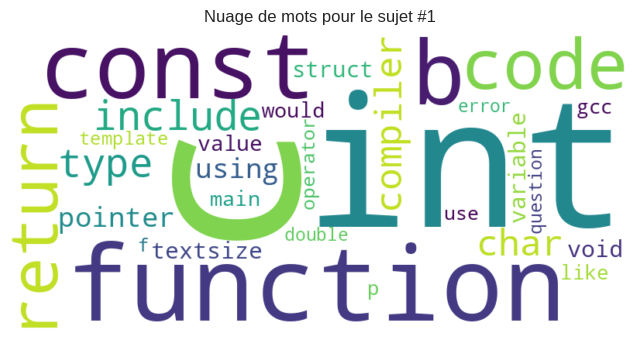

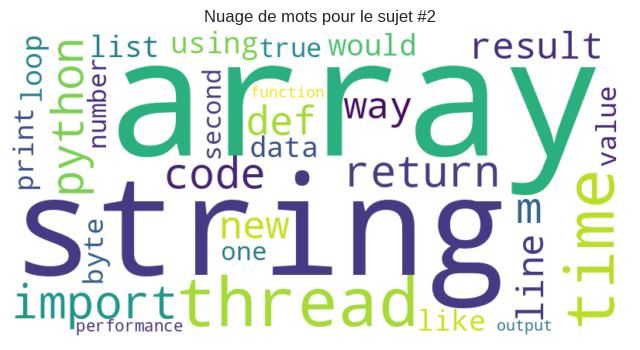

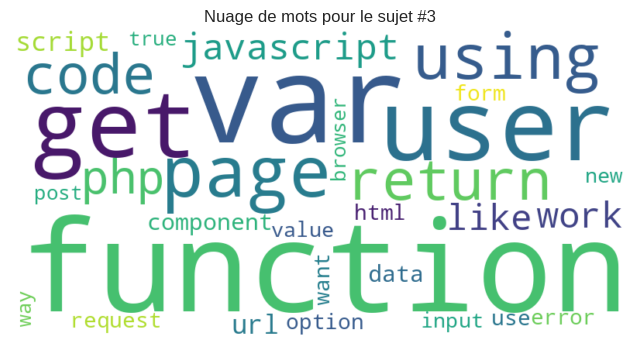

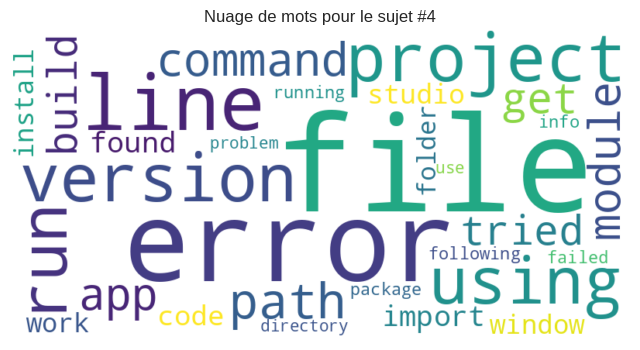

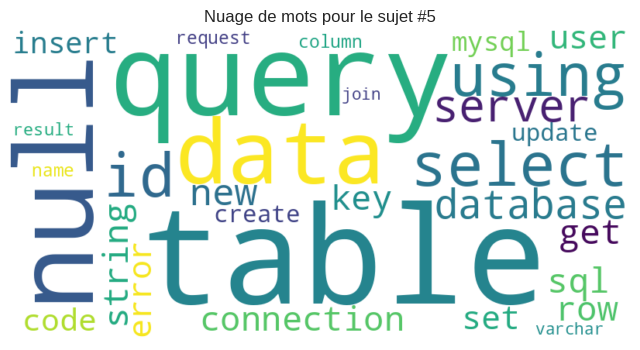

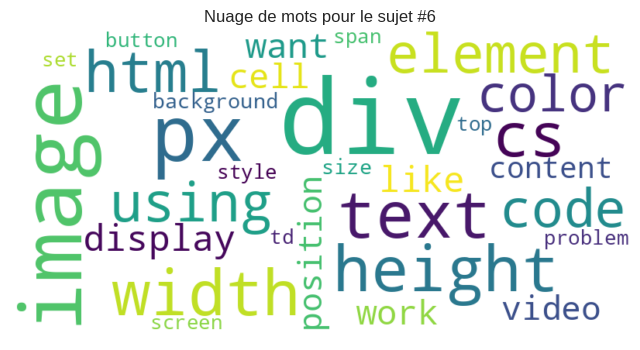

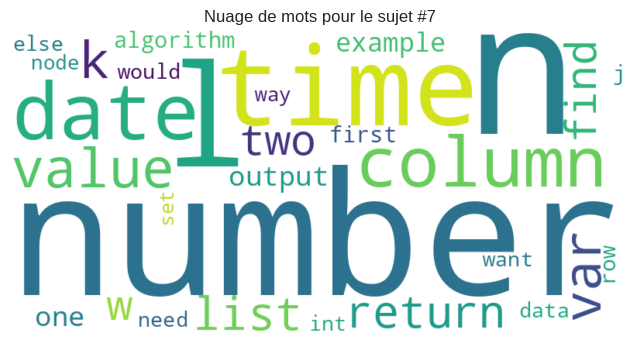

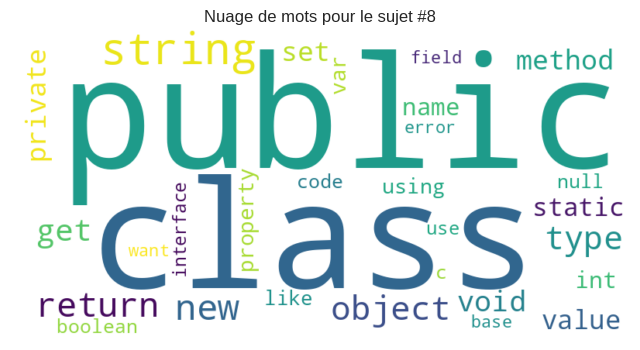

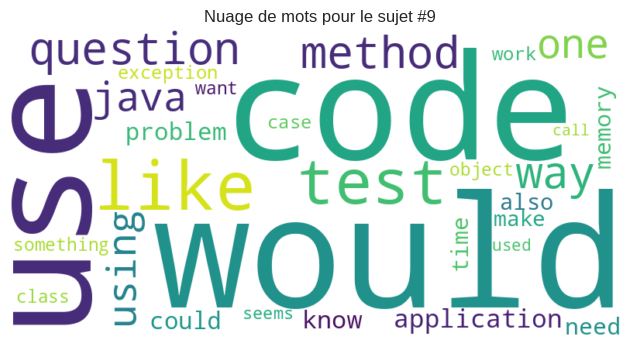

In [ ]:
# Importer les bibliothèques nécessaires
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Définir la fonction pour créer un nuage de mots pour chaque sujet
def plot_wordcloud(lda_model, topic_num):
    words = dict(lda_model.show_topic(topic_num, 30))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Nuage de mots pour le sujet #" + str(topic_num))
    plt.show()

# Utiliser la fonction pour créer un nuage de mots pour chaque sujet
for i in range(lda_model.num_topics):
    plot_wordcloud(lda_model, i)

## **TF-IDF + NMF**

In [ ]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import joblib
import gensim
from gensim import corpora, models, matutils

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

no_features = 1000
no_topics = 10
no_top_words = 10

# Tfidf vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_modelisation['post_lemmatized'])

# NMF model
nmf_model = NMF(n_components=no_topics, random_state=42)
nmf_topic_matrix = nmf_model.fit_transform(tfidf)

# Display topics
terms_nmf = tfidf_vectorizer.get_feature_names_out()
for i, topic in enumerate(nmf_model.components_):
    topic_words = [terms_nmf[idx] for idx in topic.argsort()[:-no_top_words - 1:-1]]
    print("Topic "+str(i)+": "+' '.join(topic_words))

Topic 0: error app android project application using code run version work
Topic 1: public class void method private new static object override return
Topic 2: int include const type char return struct main code compiler
Topic 3: div px html cs width height image element page text
Topic 4: string character convert char new regex text number java json
Topic 5: file line directory git read folder path php command text
Topic 6: function var return javascript object code true false like variable
Topic 7: array element list number object way size value memory item
Topic 8: import python module def line print list error package numpy
Topic 9: table query select value column row data id sql null


# **Approche supervisée**

In [15]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, hamming_loss, recall_score, precision_score
import time
from tqdm import tqdm

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

## **Fonctions pour les modèles**

In [17]:
def dico_metric(dico, col):
    dico[col] = {
        'Hamming loss': round(hamming_loss(y_test, y_pred), 2),
        'Jaccard_score': round(jaccard_score(y_test, y_pred, average="weighted"), 2),
        'f1_score': round(f1_score(y_test, y_pred, average='weighted'), 2),
        'Precision_score': round(precision_score(y_test, y_pred, average='weighted'), 2),
        'Recall': round(recall_score(y_test, y_pred, average='weighted'), 2),
        'Accuracy': round(accuracy_score(y_test, y_pred), 2)
    }
    return dico

In [18]:
def regression_log(X_train, y_train, X_test):
    model = OneVsRestClassifier(LogisticRegression(random_state=42))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

In [19]:
def sgdclassifier(X_train, y_train, X_test):
    model = OneVsRestClassifier(SGDClassifier(random_state=42))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

In [20]:
def xgboost(X_train, y_train, X_test):
    model = OneVsRestClassifier(xgb.XGBClassifier(random_state=42))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

In [21]:
def support_vector_machine(X_train, y_train, X_test):
    model = OneVsRestClassifier(LinearSVC(random_state=42))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

In [22]:
def decisiontree(X_train, y_train, X_test):
    model_dt = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
    model_dt.fit(X_train, y_train)
    y_pred = model_dt.predict(X_test)
    return y_pred

## **Encodage des tags en utilisant MultiLabelBinarizer pour la classification multi-étiquettes**

In [23]:
from sklearn.preprocessing import MultiLabelBinarizer

# Créer une instance de MultiLabelBinarizer
mlb = MultiLabelBinarizer()

tags = df_modelisation['Top_tags'].values

# Appliquer le MultiLabelBinarizer aux tags
tags_encoded = mlb.fit_transform(tags)

# Remplacer les apostrophes dans les noms de classes encodés
classes = pd.Series(mlb.classes_).str.replace("'", "")
tags_encoded = pd.DataFrame(tags_encoded, columns=classes)

# Afficher les noms de classes sans apostrophes
display(classes)

# Afficher les tags encodés pour le premier post/question
display(tags_encoded)

0                .net
1           algorithm
2             android
3             angular
4           angularjs
5              arrays
6             asp.net
7         asp.net-mvc
8                bash
9                   c
10                 c#
11                c++
12              c++11
13                css
14                gcc
15                git
16      google-chrome
17               html
18                ios
19             iphone
20               java
21         javascript
22             jquery
23               json
24    language-lawyer
25              linux
26              macos
27     multithreading
28              mysql
29            node.js
30        objective-c
31       optimization
32        performance
33                php
34             python
35         python-3.x
36                  r
37            reactjs
38              regex
39               ruby
40      ruby-on-rails
41             spring
42                sql
43         sql-server
44             string
45        

,.net,algorithm,android,angular,angularjs,arrays,asp.net,asp.net-mvc,bash,c,...,ruby-on-rails,spring,sql,sql-server,string,swift,typescript,visual-studio,windows,xcode
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44121,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44123,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


**transformer la variable cible 'Top_tags' qui contient des tags pour chaque post/question en un format adapté pour l'apprentissage supervisé**

## **Algorithme utilisiant le bow**

In [24]:
model_metrics_bow = {}

In [28]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
import numpy as np

X = bow 
y = tags_encoded

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Afficher la taille des ensembles d'entraînement et de test
print("Taille de X_train:", X_train.shape)
print("Taille de X_test:", X_test.shape)
print("Taille de y_train:", y_train.shape)
print("Taille de y_test:", y_test.shape)

Taille de X_train: (35300, 16)
Taille de X_test: (8825, 16)
Taille de y_train: (35300, 50)
Taille de y_test: (8825, 50)


### **Regression logistique**

In [29]:
%%time
y_pred = regression_log(X_train, y_train, X_test)
dico_metric(model_metrics_bow, "reg_log")
display(model_metrics_bow)

{'reg_log': {'Hamming loss': 0.03,
  'Jaccard_score': 0.01,
  'f1_score': 0.01,
  'Precision_score': 0.21,
  'Recall': 0.01,
  'Accuracy': 0.0}}

CPU times: user 4.25 s, sys: 20.4 ms, total: 4.27 s
Wall time: 4.27 s


### **SGDClassifier**

In [30]:
%%time
y_pred = sgdclassifier (X_train, y_train, X_test)
dico_metric(model_metrics_bow, "sgd")
display(model_metrics_bow)

{'reg_log': {'Hamming loss': 0.03,
  'Jaccard_score': 0.01,
  'f1_score': 0.01,
  'Precision_score': 0.21,
  'Recall': 0.01,
  'Accuracy': 0.0},
 'sgd': {'Hamming loss': 0.03,
  'Jaccard_score': 0.0,
  'f1_score': 0.0,
  'Precision_score': 0.06,
  'Recall': 0.0,
  'Accuracy': 0.0}}

CPU times: user 3.56 s, sys: 5.84 ms, total: 3.57 s
Wall time: 3.55 s


### **XGBOOST**

In [31]:
%%time
y_pred = xgboost(X_train, y_train, X_test)
dico_metric(model_metrics_bow, "xg_boost")
display(model_metrics_bow)

{'reg_log': {'Hamming loss': 0.03,
  'Jaccard_score': 0.01,
  'f1_score': 0.01,
  'Precision_score': 0.21,
  'Recall': 0.01,
  'Accuracy': 0.0},
 'sgd': {'Hamming loss': 0.03,
  'Jaccard_score': 0.0,
  'f1_score': 0.0,
  'Precision_score': 0.06,
  'Recall': 0.0,
  'Accuracy': 0.0},
 'xg_boost': {'Hamming loss': 0.03,
  'Jaccard_score': 0.02,
  'f1_score': 0.04,
  'Precision_score': 0.26,
  'Recall': 0.02,
  'Accuracy': 0.02}}

CPU times: user 3min 45s, sys: 467 ms, total: 3min 45s
Wall time: 1min


### **SVM**

In [32]:
%%time
y_pred = support_vector_machine(X_train, y_train, X_test)
dico_metric(model_metrics_bow, "svm")
display(model_metrics_bow)

{'reg_log': {'Hamming loss': 0.03,
  'Jaccard_score': 0.01,
  'f1_score': 0.01,
  'Precision_score': 0.21,
  'Recall': 0.01,
  'Accuracy': 0.0},
 'sgd': {'Hamming loss': 0.03,
  'Jaccard_score': 0.0,
  'f1_score': 0.0,
  'Precision_score': 0.06,
  'Recall': 0.0,
  'Accuracy': 0.0},
 'xg_boost': {'Hamming loss': 0.03,
  'Jaccard_score': 0.02,
  'f1_score': 0.04,
  'Precision_score': 0.26,
  'Recall': 0.02,
  'Accuracy': 0.02},
 'svm': {'Hamming loss': 0.03,
  'Jaccard_score': 0.0,
  'f1_score': 0.01,
  'Precision_score': 0.15,
  'Recall': 0.0,
  'Accuracy': 0.0}}

CPU times: user 1min 58s, sys: 61.1 ms, total: 1min 58s
Wall time: 1min 57s


### **Decision tree**

In [33]:
%%time
y_pred = decisiontree(X_train, y_train, X_test)
dico_metric(model_metrics_bow, "decision_tree")
display(model_metrics_bow)

{'reg_log': {'Hamming loss': 0.03,
  'Jaccard_score': 0.01,
  'f1_score': 0.01,
  'Precision_score': 0.21,
  'Recall': 0.01,
  'Accuracy': 0.0},
 'sgd': {'Hamming loss': 0.03,
  'Jaccard_score': 0.0,
  'f1_score': 0.0,
  'Precision_score': 0.06,
  'Recall': 0.0,
  'Accuracy': 0.0},
 'xg_boost': {'Hamming loss': 0.03,
  'Jaccard_score': 0.02,
  'f1_score': 0.04,
  'Precision_score': 0.26,
  'Recall': 0.02,
  'Accuracy': 0.02},
 'svm': {'Hamming loss': 0.03,
  'Jaccard_score': 0.0,
  'f1_score': 0.01,
  'Precision_score': 0.15,
  'Recall': 0.0,
  'Accuracy': 0.0},
 'decision_tree': {'Hamming loss': 0.05,
  'Jaccard_score': 0.06,
  'f1_score': 0.1,
  'Precision_score': 0.11,
  'Recall': 0.1,
  'Accuracy': 0.02}}

CPU times: user 17.9 s, sys: 12.1 ms, total: 17.9 s
Wall time: 17.9 s


### **Enregister les résultat des modèles via le BOW**

In [34]:
result_bow = pd.DataFrame.from_dict(model_metrics_bow)
print("-"*34 + f"Via le BOW :" + "-"*35)
display(result_bow)

----------------------------------Via le BOW :-----------------------------------


,reg_log,sgd,xg_boost,svm,decision_tree
Hamming loss,0.03,0.03,0.03,0.03,0.05
Jaccard_score,0.01,0.00,0.02,0.00,0.06
f1_score,0.01,0.00,0.04,0.01,0.10
Precision_score,0.21,0.06,0.26,0.15,0.11
Recall,0.01,0.00,0.02,0.00,0.10
Accuracy,0.00,0.00,0.02,0.00,0.02


In [37]:
result_bow.to_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_bow.csv', index=True, index_label='Metrics')

In [ ]:
bow_scores = pd.read_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_bow.csv')

In [ ]:
bow_scores

,Unnamed: 0,reg_log,sgd,xg_boost,svm,decision_tree
0,Hamming loss,0.03,0.03,0.03,0.03,0.05
1,Jaccard_score,0.01,0.00,0.02,0.00,0.06
2,f1_score,0.01,0.00,0.04,0.01,0.10
3,Precision_score,0.21,0.06,0.26,0.15,0.11
4,Recall,0.01,0.00,0.02,0.00,0.10
5,Accuracy,0.00,0.00,0.02,0.00,0.02


## **Algorithme utilisant le TF-IDF comme X**

**Création d'une liste pour les scores des métrics**

In [ ]:
# Création d'une dictionnaire pour les scores des métriques
model_metrics_tfidf = {}

**Split les données**

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
import numpy as np

X = tfidf 
y = tags_encoded

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Afficher la taille des ensembles d'entraînement et de test
print("Taille de X_train:", X_train.shape)
print("Taille de X_test:", X_test.shape)
print("Taille de y_train:", y_train.shape)
print("Taille de y_test:", y_test.shape)

Taille de X_train: (35300, 1000)
Taille de X_test: (8825, 1000)
Taille de y_train: (35300, 50)
Taille de y_test: (8825, 50)


### **Regression logistique**

In [ ]:
%%time
y_pred = regression_log(X_train, y_train, X_test)
dico_metric(model_metrics_tfidf, "reg_log")
display(model_metrics_tfidf)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.43,
  'f1_score': 0.57,
  'Precision_score': 0.8,
  'Recall': 0.47,
  'Accuracy': 0.35}}

CPU times: user 11.6 s, sys: 30.3 ms, total: 11.6 s
Wall time: 11.5 s


### **SGDClassifier**

In [ ]:
%%time
y_pred = sgdclassifier (X_train, y_train, X_test)
dico_metric(model_metrics_tfidf, "sgd")
display(model_metrics_tfidf)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.43,
  'f1_score': 0.57,
  'Precision_score': 0.8,
  'Recall': 0.47,
  'Accuracy': 0.35},
 'sgd': {'Hamming loss': 0.02,
  'Jaccard_score': 0.41,
  'f1_score': 0.54,
  'Precision_score': 0.76,
  'Recall': 0.44,
  'Accuracy': 0.34}}

CPU times: user 2.24 s, sys: 2.03 ms, total: 2.24 s
Wall time: 2.23 s


### **XGBOOST**

In [ ]:
%%time
y_pred = xgboost(X_train, y_train, X_test)
dico_metric(model_metrics_tfidf, "xg_boost")
display(model_metrics_tfidf)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.43,
  'f1_score': 0.57,
  'Precision_score': 0.8,
  'Recall': 0.47,
  'Accuracy': 0.35},
 'sgd': {'Hamming loss': 0.02,
  'Jaccard_score': 0.41,
  'f1_score': 0.54,
  'Precision_score': 0.76,
  'Recall': 0.44,
  'Accuracy': 0.34},
 'xg_boost': {'Hamming loss': 0.02,
  'Jaccard_score': 0.5,
  'f1_score': 0.64,
  'Precision_score': 0.77,
  'Recall': 0.56,
  'Accuracy': 0.4}}

CPU times: user 1h 4min 28s, sys: 1.97 s, total: 1h 4min 30s
Wall time: 5min 30s


### **SVM**

In [ ]:
%%time
y_pred = support_vector_machine(X_train, y_train, X_test)
dico_metric(model_metrics_tfidf, "svm")
display(model_metrics_tfidf)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.43,
  'f1_score': 0.57,
  'Precision_score': 0.8,
  'Recall': 0.47,
  'Accuracy': 0.35},
 'sgd': {'Hamming loss': 0.02,
  'Jaccard_score': 0.41,
  'f1_score': 0.54,
  'Precision_score': 0.76,
  'Recall': 0.44,
  'Accuracy': 0.34},
 'xg_boost': {'Hamming loss': 0.02,
  'Jaccard_score': 0.5,
  'f1_score': 0.64,
  'Precision_score': 0.77,
  'Recall': 0.56,
  'Accuracy': 0.4},
 'svm': {'Hamming loss': 0.02,
  'Jaccard_score': 0.47,
  'f1_score': 0.61,
  'Precision_score': 0.78,
  'Recall': 0.52,
  'Accuracy': 0.38}}

CPU times: user 4.88 s, sys: 4.05 ms, total: 4.88 s
Wall time: 4.86 s


### **Decision tree**

In [ ]:
%%time
y_pred = decisiontree(X_train, y_train, X_test)
dico_metric(model_metrics_tfidf, "decision_tree")
display(model_metrics_tfidf)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.43,
  'f1_score': 0.57,
  'Precision_score': 0.8,
  'Recall': 0.47,
  'Accuracy': 0.35},
 'sgd': {'Hamming loss': 0.02,
  'Jaccard_score': 0.41,
  'f1_score': 0.54,
  'Precision_score': 0.76,
  'Recall': 0.44,
  'Accuracy': 0.34},
 'xg_boost': {'Hamming loss': 0.02,
  'Jaccard_score': 0.5,
  'f1_score': 0.64,
  'Precision_score': 0.77,
  'Recall': 0.56,
  'Accuracy': 0.4},
 'svm': {'Hamming loss': 0.02,
  'Jaccard_score': 0.47,
  'f1_score': 0.61,
  'Precision_score': 0.78,
  'Recall': 0.52,
  'Accuracy': 0.38},
 'decision_tree': {'Hamming loss': 0.03,
  'Jaccard_score': 0.4,
  'f1_score': 0.54,
  'Precision_score': 0.56,
  'Recall': 0.54,
  'Accuracy': 0.25}}

CPU times: user 8min 56s, sys: 333 ms, total: 8min 57s
Wall time: 8min 54s


### **Enregister les résultat des modèles via le TF-IDF**

In [ ]:
result_tfidf = pd.DataFrame.from_dict(model_metrics_tfidf)
print("-"*34 + f"Via le TF-IDF :" + "-"*35)
display(result_tfidf)

----------------------------------Via le TF-IDF :-----------------------------------


,reg_log,sgd,xg_boost,svm,decision_tree
Hamming loss,0.02,0.02,0.02,0.02,0.03
Jaccard_score,0.43,0.41,0.50,0.47,0.40
f1_score,0.57,0.54,0.64,0.61,0.54
Precision_score,0.80,0.76,0.77,0.78,0.56
Recall,0.47,0.44,0.56,0.52,0.54
Accuracy,0.35,0.34,0.40,0.38,0.25


In [ ]:
result_tfidf.to_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_tfidf.csv', index=True, index_label='Metrics')

In [ ]:
tfidf_scores = pd.read_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_tfidf.csv')

In [ ]:
tfidf_scores

,Unnamed: 0,reg_log,sgd,xg_boost,svm,decision_tree
0,Hamming loss,0.02,0.02,0.02,0.02,0.03
1,Jaccard_score,0.43,0.41,0.50,0.47,0.40
2,f1_score,0.57,0.54,0.64,0.61,0.54
3,Precision_score,0.80,0.76,0.77,0.78,0.56
4,Recall,0.47,0.44,0.56,0.52,0.54
5,Accuracy,0.35,0.34,0.40,0.38,0.25


## **Algorithme utilisant word2vec**

In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [ ]:
import nltk
from nltk.corpus import stopwords
import string

import nltk

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenize(text):

    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    try:
        res = word_tokenize(text, language='english')
    except TypeError:
        return text

    res = [token for token in res if token not in punctuation]
    res = [token for token in res if token not in stop_words]
   # res = [token for token in res if token not in letters]
    return res

In [ ]:
import numpy as np

# Créer un tableau des longueurs des phrases
phrase_lengths = np.array([len(phrase.split()) for phrase in df['post_lemmatized']])

# Calculer la moyenne et l'écart-type des longueurs des phrases
mean_length = np.mean(phrase_lengths)
std_length = np.std(phrase_lengths)

# Afficher la moyenne et l'écart-type des longueurs des phrases
print(f"Moyenne de la longueur des phrases : {mean_length:.2f}")
print(f"Ecart-type de la longueur des phrases : {std_length:.2f}")

# Déterminer la longueur maximale des phrases en fonction de la moyenne et de l'écart-type
maxlen = int(mean_length + 2 * std_length)
print(f"Longueur maximale recommandée : {maxlen}")

Moyenne de la longueur des phrases : 114.68
Ecart-type de la longueur des phrases : 121.22
Longueur maximale recommandée : 357


In [ ]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 357 # adapt to length of sentences
sentences = df['post_lemmatized'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
%%time
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 234175
Word2Vec trained
CPU times: user 25min 36s, sys: 4.91 s, total: 25min 41s
Wall time: 25min 24s


In [ ]:
%%time
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 234176
CPU times: user 5.34 s, sys: 102 ms, total: 5.44 s
Wall time: 5.42 s


### **Création de la matrice d'embedding**

In [ ]:
%%time
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (234176, 300)
CPU times: user 12min 46s, sys: 4.49 s, total: 12min 50s
Wall time: 12min 45s


### **Création du modèle d'embedding**

In [ ]:
%%time
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 357)]             0         
                                                                 
 embedding (Embedding)       (None, 357, 300)          70252800  
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 70,252,800
Trainable params: 70,252,800
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1.01 s, sys: 640 ms, total: 1.65 s
Wall time: 3.51 s


In [ ]:
import pickle

In [ ]:
# Enregistrer le modèle entraîné
with open('/content/drive/MyDrive/IML OPENCLASSROOMS/PROJET_5/x_sentences.pickle', 'wb') as f:
    pickle.dump(x_sentences, f)

In [ ]:
# Charger le modèle enregistré
with open('/content/drive/MyDrive/IML OPENCLASSROOMS/PROJET_5/x_sentences.pickle', 'rb') as f:
    x_sentences = pickle.load(f)

In [ ]:
x_sentences.shape

(44125, 357)

**Train test via Word2vec**

In [ ]:
from sklearn.model_selection import train_test_split
X = x_sentences 
y = tags_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Afficher la taille des ensembles d'entraînement et de test
print("Taille de X_train:", X_train.shape)
print("Taille de X_test:", X_test.shape)
print("Taille de y_train:", y_train.shape)
print("Taille de y_test:", y_test.shape)

Taille de X_train: (35300, 357)
Taille de X_test: (8825, 357)
Taille de y_train: (35300, 50)
Taille de y_test: (8825, 50)


In [ ]:
# Création d'une dictionnaire pour les scores des métriques
model_metrics_wv = {}

### **Regression logistique**

In [ ]:
%%time
y_pred = regression_log(X_train, y_train, X_test)
dico_metric (model_metrics_wv, "reg_log")
display(model_metrics_wv)

{'reg_log': {'Hamming loss': 0.03,
  'Jaccard_score': 0.0,
  'f1_score': 0.01,
  'Precision_score': 0.07,
  'Recall': 0.0,
  'Accuracy': 0.0}}

CPU times: user 6min 9s, sys: 3min 44s, total: 9min 54s
Wall time: 51.4 s


### **SGDClassifier**

In [ ]:
%%time
y_pred = sgdclassifier (X_train, y_train, X_test)
dico_metric (model_metrics_wv, "sgd")
display(model_metrics_wv)

{'reg_log': {'Hamming loss': 0.03,
  'Jaccard_score': 0.0,
  'f1_score': 0.01,
  'Precision_score': 0.07,
  'Recall': 0.0,
  'Accuracy': 0.0},
 'sgd': {'Hamming loss': 0.06,
  'Jaccard_score': 0.04,
  'f1_score': 0.07,
  'Precision_score': 0.07,
  'Recall': 0.08,
  'Accuracy': 0.01}}

CPU times: user 3min 59s, sys: 3.56 s, total: 4min 3s
Wall time: 3min 58s


### **XGBOOST**

In [ ]:
%%time
y_pred = xgboost(X_train, y_train, X_test)
dico_metric(model_metrics_wv, "xg_boost")
display(model_metrics_wv)

{'reg_log': {'Hamming loss': 0.03,
  'Jaccard_score': 0.0,
  'f1_score': 0.01,
  'Precision_score': 0.07,
  'Recall': 0.0,
  'Accuracy': 0.0},
 'sgd': {'Hamming loss': 0.06,
  'Jaccard_score': 0.04,
  'f1_score': 0.07,
  'Precision_score': 0.07,
  'Recall': 0.08,
  'Accuracy': 0.01},
 'xg_boost': {'Hamming loss': 0.03,
  'Jaccard_score': 0.14,
  'f1_score': 0.22,
  'Precision_score': 0.72,
  'Recall': 0.14,
  'Accuracy': 0.12}}

CPU times: user 2h 8min 57s, sys: 8.11 s, total: 2h 9min 5s
Wall time: 11min 8s


### **SVM**

In [ ]:
%%time
y_pred = support_vector_machine(X_train, y_train, X_test)
dico_metric(model_metrics_wv, "svm")
display(model_metrics_wv)

{'reg_log': {'Hamming loss': 0.03,
  'Jaccard_score': 0.0,
  'f1_score': 0.01,
  'Precision_score': 0.07,
  'Recall': 0.0,
  'Accuracy': 0.0},
 'sgd': {'Hamming loss': 0.06,
  'Jaccard_score': 0.04,
  'f1_score': 0.07,
  'Precision_score': 0.07,
  'Recall': 0.08,
  'Accuracy': 0.01},
 'xg_boost': {'Hamming loss': 0.03,
  'Jaccard_score': 0.14,
  'f1_score': 0.22,
  'Precision_score': 0.72,
  'Recall': 0.14,
  'Accuracy': 0.12},
 'svm': {'Hamming loss': 0.23,
  'Jaccard_score': 0.05,
  'f1_score': 0.1,
  'Precision_score': 0.07,
  'Recall': 0.27,
  'Accuracy': 0.0}}

CPU times: user 13min 33s, sys: 5.6 s, total: 13min 39s
Wall time: 13min 32s


### **Decision tree**

In [ ]:
%%time
y_pred = decisiontree(X_train, y_train, X_test)
dico_metric(model_metrics_wv, "decision_tree")
display(model_metrics_wv)

{'reg_log': {'Hamming loss': 0.03,
  'Jaccard_score': 0.0,
  'f1_score': 0.01,
  'Precision_score': 0.07,
  'Recall': 0.0,
  'Accuracy': 0.0},
 'sgd': {'Hamming loss': 0.06,
  'Jaccard_score': 0.04,
  'f1_score': 0.07,
  'Precision_score': 0.07,
  'Recall': 0.08,
  'Accuracy': 0.01},
 'xg_boost': {'Hamming loss': 0.03,
  'Jaccard_score': 0.14,
  'f1_score': 0.22,
  'Precision_score': 0.72,
  'Recall': 0.14,
  'Accuracy': 0.12},
 'svm': {'Hamming loss': 0.23,
  'Jaccard_score': 0.05,
  'f1_score': 0.1,
  'Precision_score': 0.07,
  'Recall': 0.27,
  'Accuracy': 0.0},
 'decision_tree': {'Hamming loss': 0.06,
  'Jaccard_score': 0.09,
  'f1_score': 0.16,
  'Precision_score': 0.14,
  'Recall': 0.18,
  'Accuracy': 0.04}}

CPU times: user 10min 46s, sys: 973 ms, total: 10min 47s
Wall time: 10min 44s


### **Enregister les résultat des modèles via le Word2vec**

In [ ]:
result_wv = pd.DataFrame.from_dict(model_metrics_wv)
print("-"*34 + f"Via le WORD2VEC :" + "-"*35)
display(result_wv)

----------------------------------Via le WORD2VEC :-----------------------------------


,reg_log,sgd,xg_boost,svm,decision_tree
Hamming loss,0.03,0.06,0.03,0.23,0.06
Jaccard_score,0.00,0.04,0.14,0.05,0.09
f1_score,0.01,0.07,0.22,0.10,0.16
Precision_score,0.07,0.07,0.72,0.07,0.14
Recall,0.00,0.08,0.14,0.27,0.18
Accuracy,0.00,0.01,0.12,0.00,0.04


In [ ]:
result_wv.to_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_wv.csv', index=True, index_label='Metrics')

In [ ]:
scores_wv = pd.read_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_wv.csv')

In [ ]:
scores_wv

,Unnamed: 0,reg_log,sgd,xg_boost,svm,decision_tree
0,Hamming loss,0.03,0.06,0.03,0.23,0.06
1,Jaccard_score,0.00,0.04,0.14,0.05,0.09
2,f1_score,0.01,0.07,0.22,0.10,0.16
3,Precision_score,0.07,0.07,0.72,0.07,0.14
4,Recall,0.00,0.08,0.14,0.27,0.18
5,Accuracy,0.00,0.01,0.12,0.00,0.04


## **Algorithme utilisant BERT**

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 74.2 MB/s eta 0:00:00


In [ ]:
import tensorflow_text as text

In [ ]:
import tensorflow as tf

print("Version de TensorFlow :", tf.__version__)
print("Version de Tensorflow texte :", text.__version__)
print("Version de transformers :", transformers.__version__)

Version de TensorFlow : 2.12.0
Version de Tensorflow texte : 2.12.1
Version de transformers : 4.29.1


### **Fonctions communes**

In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot

In [ ]:
# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
### **Logistique regression**
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

### **Mise en place du BERT**

In [ ]:
import tensorflow as tf

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
Num GPUs Available:  1
True


In [ ]:
max_length = 357
batch_size = 16
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['post_cleaned'][:10000].tolist()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tf_model.h5
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training

In [ ]:
%%time
import time
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

1/1 [==============================] - 0s 27ms/step
temps traitement :  1623.0
CPU times: user 16min 33s, sys: 10min 38s, total: 27min 11s
Wall time: 27min 5s


In [ ]:
# Enregistrer le modèle entraîné
with open('/content/drive/MyDrive/IML OPENCLASSROOMS/PROJET_5/features_bert', 'wb') as f:
    pickle.dump(features_bert, f)

In [ ]:
# Charger le modèle enregistré
with open('/content/drive/MyDrive/IML OPENCLASSROOMS/PROJET_5/features_bert', 'rb') as f:
    features_bert = pickle.load(f)

**Train test via BERT**

In [ ]:
from sklearn.model_selection import train_test_split

X = features_bert
y = tags_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_metrics_bert = {} # Garde en mémoire les scores

### **Regression logistique**

In [ ]:
%%time
y_pred = regression_log(X_train, y_train, X_test)
dico_metric (model_metrics_bert, "reg_log")
display(model_metrics_bert)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.28,
  'f1_score': 0.41,
  'Precision_score': 0.68,
  'Recall': 0.31,
  'Accuracy': 0.22}}

CPU times: user 1min 10s, sys: 31.3 s, total: 1min 42s
Wall time: 29.3 s


### **SGDClassifier**

In [ ]:
%%time
y_pred = sgdclassifier (X_train, y_train, X_test)
dico_metric (model_metrics_bert, "sgd")
display(model_metrics_bert)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.28,
  'f1_score': 0.41,
  'Precision_score': 0.68,
  'Recall': 0.31,
  'Accuracy': 0.22},
 'sgd': {'Hamming loss': 0.03,
  'Jaccard_score': 0.28,
  'f1_score': 0.41,
  'Precision_score': 0.59,
  'Recall': 0.37,
  'Accuracy': 0.21}}

CPU times: user 25.2 s, sys: 968 ms, total: 26.2 s
Wall time: 25.3 s


### **XGBOOST**

In [ ]:
%%time
y_pred = xgboost(X_train, y_train, X_test)
dico_metric(model_metrics_bert, "xg_boost")
display(model_metrics_bert)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.28,
  'f1_score': 0.41,
  'Precision_score': 0.68,
  'Recall': 0.31,
  'Accuracy': 0.22},
 'sgd': {'Hamming loss': 0.03,
  'Jaccard_score': 0.28,
  'f1_score': 0.41,
  'Precision_score': 0.59,
  'Recall': 0.37,
  'Accuracy': 0.21},
 'xg_boost': {'Hamming loss': 0.03,
  'Jaccard_score': 0.14,
  'f1_score': 0.23,
  'Precision_score': 0.63,
  'Recall': 0.15,
  'Accuracy': 0.11}}

CPU times: user 1h 45min 58s, sys: 749 ms, total: 1h 45min 58s
Wall time: 28min 38s


### **SVM**

In [ ]:
%%time
y_pred = support_vector_machine(X_train, y_train, X_test)
dico_metric(model_metrics_bert, "svm")
display(model_metrics_bert)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.28,
  'f1_score': 0.41,
  'Precision_score': 0.68,
  'Recall': 0.31,
  'Accuracy': 0.22},
 'sgd': {'Hamming loss': 0.03,
  'Jaccard_score': 0.28,
  'f1_score': 0.41,
  'Precision_score': 0.59,
  'Recall': 0.37,
  'Accuracy': 0.21},
 'xg_boost': {'Hamming loss': 0.03,
  'Jaccard_score': 0.14,
  'f1_score': 0.23,
  'Precision_score': 0.63,
  'Recall': 0.15,
  'Accuracy': 0.11},
 'svm': {'Hamming loss': 0.03,
  'Jaccard_score': 0.32,
  'f1_score': 0.46,
  'Precision_score': 0.59,
  'Recall': 0.39,
  'Accuracy': 0.23}}

CPU times: user 2min 30s, sys: 3.55 s, total: 2min 34s
Wall time: 2min 32s


### **Decision tree**

In [ ]:
%%time
y_pred = decisiontree(X_train, y_train, X_test)
dico_metric(model_metrics_bert, "decision_tree")
display(model_metrics_bert)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.28,
  'f1_score': 0.41,
  'Precision_score': 0.68,
  'Recall': 0.31,
  'Accuracy': 0.22},
 'sgd': {'Hamming loss': 0.03,
  'Jaccard_score': 0.28,
  'f1_score': 0.41,
  'Precision_score': 0.59,
  'Recall': 0.37,
  'Accuracy': 0.21},
 'xg_boost': {'Hamming loss': 0.03,
  'Jaccard_score': 0.14,
  'f1_score': 0.23,
  'Precision_score': 0.63,
  'Recall': 0.15,
  'Accuracy': 0.11},
 'svm': {'Hamming loss': 0.03,
  'Jaccard_score': 0.32,
  'f1_score': 0.46,
  'Precision_score': 0.59,
  'Recall': 0.39,
  'Accuracy': 0.23},
 'decision_tree': {'Hamming loss': 0.06,
  'Jaccard_score': 0.1,
  'f1_score': 0.18,
  'Precision_score': 0.17,
  'Recall': 0.2,
  'Accuracy': 0.05}}

CPU times: user 18min 4s, sys: 1.78 s, total: 18min 6s
Wall time: 17min 59s


### **Enregister les résultat des modèles via le BERT**

In [ ]:
result_bert = pd.DataFrame.from_dict(model_metrics_bert)
print("-"*34 + f"Via le BERT :" + "-"*35)
display(result_bert)

----------------------------------Via le BERT :-----------------------------------


,reg_log,sgd,xg_boost,svm,decision_tree
Hamming loss,0.02,0.03,0.03,0.03,0.06
Jaccard_score,0.28,0.28,0.14,0.32,0.10
f1_score,0.41,0.41,0.23,0.46,0.18
Precision_score,0.68,0.59,0.63,0.59,0.17
Recall,0.31,0.37,0.15,0.39,0.20
Accuracy,0.22,0.21,0.11,0.23,0.05


In [ ]:
result_bert.to_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_bert.csv', index=True, index_label='Metrics')

In [ ]:
scores_bert = pd.read_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_bert.csv')

In [ ]:
scores_bert

,Metrics,reg_log,sgd,xg_boost,svm,decision_tree
0,Hamming loss,0.02,0.03,0.03,0.03,0.06
1,Jaccard_score,0.28,0.28,0.14,0.32,0.10
2,f1_score,0.41,0.41,0.23,0.46,0.18
3,Precision_score,0.68,0.59,0.63,0.59,0.17
4,Recall,0.31,0.37,0.15,0.39,0.20
5,Accuracy,0.22,0.21,0.11,0.23,0.05


## **Algorithme utilisant USE**

### **Mise en place du USE**

In [ ]:
pip install tensorflow-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub

In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  1
True


In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()
    features_list = []

    num_batches = len(sentences) // batch_size

    for step in range(num_batches):
        idx = step * batch_size
        feat = embed(sentences[idx:idx+batch_size])
        features_list.append(feat)

    # Traiter les phrases restantes
    if len(sentences) % batch_size != 0:
        last_batch = sentences[num_batches * batch_size:]
        feat = embed(last_batch)
        features_list.append(feat)

    features = np.concatenate(features_list)
    time2 = np.round(time.time() - time1, 0)
    return features

In [ ]:
batch_size = 12
sentences = df['post_cleaned'].to_list()

In [ ]:
%%time
features_USE = feature_USE_fct(sentences, batch_size)

print("Dimension des données initiales : ", len(sentences))
print("Dimension des features USE : ", features_USE.shape)

Dimension des données initiales :  44125
Dimension des features USE :  (44125, 512)
CPU times: user 1min 17s, sys: 5.46 s, total: 1min 22s
Wall time: 1min 8s


In [ ]:
import pickle

# Sauvegarder le modèle
with open('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)

### **Train test via USE**

In [ ]:
from sklearn.model_selection import train_test_split
X = features_USE
y = tags_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Créer un dictionnaire pour le USE**

In [ ]:
model_metrics_use = {}

In [ ]:
%%time
y_pred = regression_log(X_train, y_train, X_test)
dico_metric (model_metrics_use, "reg_log")
display(model_metrics_use)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.53,
  'f1_score': 0.66,
  'Precision_score': 0.8,
  'Recall': 0.59,
  'Accuracy': 0.44}}

CPU times: user 2min 11s, sys: 59.5 s, total: 3min 11s
Wall time: 1min 3s


### **SGDClassifier**

In [ ]:
%%time
y_pred = sgdclassifier (X_train, y_train, X_test)
dico_metric (model_metrics_use, "sgd")
display(model_metrics_use)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.53,
  'f1_score': 0.66,
  'Precision_score': 0.8,
  'Recall': 0.59,
  'Accuracy': 0.44},
 'sgd': {'Hamming loss': 0.02,
  'Jaccard_score': 0.5,
  'f1_score': 0.61,
  'Precision_score': 0.73,
  'Recall': 0.55,
  'Accuracy': 0.44}}

CPU times: user 15.7 s, sys: 2.42 s, total: 18.1 s
Wall time: 16.5 s


### **XGBOOST**

In [ ]:
%%time
y_pred = xgboost(X_train, y_train, X_test)
dico_metric(model_metrics_use, "xg_boost")
display(model_metrics_use)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.53,
  'f1_score': 0.66,
  'Precision_score': 0.8,
  'Recall': 0.59,
  'Accuracy': 0.44},
 'sgd': {'Hamming loss': 0.02,
  'Jaccard_score': 0.5,
  'f1_score': 0.61,
  'Precision_score': 0.73,
  'Recall': 0.55,
  'Accuracy': 0.44},
 'xg_boost': {'Hamming loss': 0.02,
  'Jaccard_score': 0.54,
  'f1_score': 0.67,
  'Precision_score': 0.79,
  'Recall': 0.6,
  'Accuracy': 0.46}}

CPU times: user 6h 36min 26s, sys: 30.1 s, total: 6h 36min 56s
Wall time: 1h 47min 41s


### **SVM**

In [ ]:
%%time
y_pred = support_vector_machine(X_train, y_train, X_test)
dico_metric(model_metrics_use, "svm")
display(model_metrics_use)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.53,
  'f1_score': 0.66,
  'Precision_score': 0.8,
  'Recall': 0.59,
  'Accuracy': 0.44},
 'sgd': {'Hamming loss': 0.02,
  'Jaccard_score': 0.5,
  'f1_score': 0.61,
  'Precision_score': 0.73,
  'Recall': 0.55,
  'Accuracy': 0.44},
 'xg_boost': {'Hamming loss': 0.02,
  'Jaccard_score': 0.54,
  'f1_score': 0.67,
  'Precision_score': 0.79,
  'Recall': 0.6,
  'Accuracy': 0.46},
 'svm': {'Hamming loss': 0.02,
  'Jaccard_score': 0.55,
  'f1_score': 0.68,
  'Precision_score': 0.79,
  'Recall': 0.63,
  'Accuracy': 0.46}}

CPU times: user 45.2 s, sys: 8.98 s, total: 54.2 s
Wall time: 52.5 s


### **Decision tree**

In [ ]:
%%time
y_pred = decisiontree(X_train, y_train, X_test)
dico_metric(model_metrics_use, "decision_tree")
display(model_metrics_use)

{'reg_log': {'Hamming loss': 0.02,
  'Jaccard_score': 0.53,
  'f1_score': 0.66,
  'Precision_score': 0.8,
  'Recall': 0.59,
  'Accuracy': 0.44},
 'sgd': {'Hamming loss': 0.02,
  'Jaccard_score': 0.5,
  'f1_score': 0.61,
  'Precision_score': 0.73,
  'Recall': 0.55,
  'Accuracy': 0.44},
 'xg_boost': {'Hamming loss': 0.02,
  'Jaccard_score': 0.54,
  'f1_score': 0.67,
  'Precision_score': 0.79,
  'Recall': 0.6,
  'Accuracy': 0.46},
 'svm': {'Hamming loss': 0.02,
  'Jaccard_score': 0.55,
  'f1_score': 0.68,
  'Precision_score': 0.79,
  'Recall': 0.63,
  'Accuracy': 0.46},
 'decision_tree': {'Hamming loss': 0.03,
  'Jaccard_score': 0.37,
  'f1_score': 0.52,
  'Precision_score': 0.51,
  'Recall': 0.53,
  'Accuracy': 0.23}}

CPU times: user 37min 1s, sys: 1.71 s, total: 37min 3s
Wall time: 36min 53s


### **Enregister les résultat des modèles via le USE**

In [ ]:
result_use = pd.DataFrame.from_dict(model_metrics_use)
print("-"*34 + f"Via le USE :" + "-"*35)
display(result_use)

----------------------------------Via le USE :-----------------------------------


,reg_log,sgd,xg_boost,svm,decision_tree
Hamming loss,0.02,0.02,0.02,0.02,0.03
Jaccard_score,0.53,0.50,0.54,0.55,0.37
f1_score,0.66,0.61,0.67,0.68,0.52
Precision_score,0.80,0.73,0.79,0.79,0.51
Recall,0.59,0.55,0.60,0.63,0.53
Accuracy,0.44,0.44,0.46,0.46,0.23


In [ ]:
result_use.to_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_use.csv', index=True, index_label = 'Metrics')

In [ ]:
use_scores = pd.read_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_use.csv')

In [ ]:
use_scores

,Metrics,reg_log,sgd,xg_boost,svm,decision_tree
0,Hamming loss,0.02,0.02,0.02,0.02,0.03
1,Jaccard_score,0.53,0.50,0.54,0.55,0.37
2,f1_score,0.66,0.61,0.67,0.68,0.52
3,Precision_score,0.80,0.73,0.79,0.79,0.51
4,Recall,0.59,0.55,0.60,0.63,0.53
5,Accuracy,0.44,0.44,0.46,0.46,0.23


# **Analyser les scores**

In [ ]:
# Define your dataframes
bow_scores = pd.read_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_bow.csv')
tfidf_scores = pd.read_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_tfidf.csv')
wv_scores = pd.read_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_wv.csv')
bert_scores = pd.read_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_bert.csv')
use_scores = pd.read_csv('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/resultat_score_use.csv')

# Rename the 'Unnamed: 0' column to 'Metrics' for all dataframes
bow_scores = bow_scores.rename(columns={'Unnamed: 0': 'Metrics'})
tfidf_scores = tfidf_scores.rename(columns={'Unnamed: 0': 'Metrics'})
wv_scores = wv_scores.rename(columns={'Unnamed: 0': 'Metrics'})

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

def plot_compare_scores(scores, title):
    fig = go.Figure()
    models = ['reg_log', 'sgd', 'xg_boost', 'svm', 'decision_tree']

    for model in models:
        fig.add_trace(go.Bar(x=scores['Metrics'], y=scores[model], name=model))

    fig.update_layout(barmode='group', legend_title_text='model', title=title, title_x=0.5)
    pio.show(fig)

In [ ]:
datasets = [bow_scores, tfidf_scores, wv_scores, bert_scores, use_scores]
titles = ['Bow Scores', 'TF-IDF Scores', 'W2V Scores', 'BERT Scores', 'USE Scores']

for dataset, title in zip(datasets, titles):
    plot_compare_scores(dataset, title)

# **Optimisiation du meilleur modèle (svm) avec USE**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, jaccard_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, jaccard_score, f1_score, precision_score, recall_score, accuracy_score

In [ ]:
def support_vector_machine(X_train, y_train, X_test):
    parameters = {
                  'estimator__C': [0.1, 1, 10, 100],  # Valeurs possibles pour le paramètre C
                  'estimator__class_weight': [None, 'balanced'],  # Valeurs possibles pour le poids de classe
                  'estimator__penalty': ['l1','l2'],  # Valeurs possibles pour le type de régularisation
                  'estimator__loss': ['hinge', 'squared_hinge'],  # Valeurs possibles pour la fonction de perte
                  'estimator__dual': [True, False]
                  }
    
    model = OneVsRestClassifier(LinearSVC(random_state=42))
    
    # Créer une fonction de score personnalisée pour le score de Jaccard
    jaccard_scorer = make_scorer(jaccard_score, average='weighted')

    # Utiliser la fonction de score personnalisée dans GridSearchCV
    grid_search = GridSearchCV(model, parameters, scoring=jaccard_scorer, cv=5)
    grid_search.fit(X_train, y_train)
        
    # Affichage des meilleurs paramètres
    print("Meilleurs paramètres :", grid_search.best_params_)
    
    # Entraînement du modèle avec les meilleurs paramètres
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    
    # Prédictions sur les données de test
    y_pred = best_model.predict(X_test)
    
    # Calcul des scores
    hamming_loss_score = round(hamming_loss(y_test, y_pred),2)
    jaccard_score_score = round(jaccard_score(y_test, y_pred, average='weighted'),2)
    f1_score_score = round(f1_score(y_test, y_pred, average='weighted'),2)
    precision_score_score = round(precision_score(y_test, y_pred, average='weighted'),2)
    recall_score_score = round(recall_score(y_test, y_pred, average='weighted'),2)
    accuracy_score_score = round(accuracy_score(y_test, y_pred),2)
    
    # Affichage des scores
    print("Scores :")
    print("Hamming Loss :", hamming_loss_score)
    print("Jaccard Score :", jaccard_score_score)
    print("F1 Score :", f1_score_score)
    print("Precision Score :", precision_score_score)
    print("Recall Score :", recall_score_score)
    print("Accuracy Score :", accuracy_score_score)
    
    return y_pred, best_model


In [ ]:
%%time
y_pred, model = support_vector_machine(X_train, y_train, X_test)

Meilleurs paramètres : {'estimator__C': 1, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2'}
Scores :
Hamming Loss : 0.02
Jaccard Score : 0.55
F1 Score : 0.68
Precision Score : 0.79
Recall Score : 0.62
Accuracy Score : 0.46
CPU times: user 25min 58s, sys: 2min 8s, total: 28min 6s
Wall time: 27min 37s


In [ ]:
import pickle

# Sauvegarder le modèle
with open('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
import pickle

# Charger le modèle
with open('/content/drive/My Drive/IML OPENCLASSROOMS/PROJET_5/saved_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
